In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")


In [3]:
# Load CSV file
file_path = r"C:\AAA\datamites projects\PRCL-0012- Business Case (client)\itsm_dataset.csv"  
df = pd.read_csv(file_path)



In [4]:
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,...,NaN,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,...,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,...,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927,...,NaN,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1.0,SD0000025,NaN,NaN,NaN
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258,...,NaN,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1.0,SD0000029,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CI_Name                     46606 non-null  object 
 1   CI_Cat                      46495 non-null  object 
 2   CI_Subcat                   46495 non-null  object 
 3   WBS                         46606 non-null  object 
 4   Incident_ID                 46606 non-null  object 
 5   Status                      46606 non-null  object 
 6   Impact                      46606 non-null  object 
 7   Urgency                     46606 non-null  object 
 8   Priority                    45226 non-null  float64
 9   number_cnt                  46606 non-null  float64
 10  Category                    46606 non-null  object 
 11  KB_number                   46606 non-null  object 
 12  Alert_Status                46606 non-null  object 
 13  No_of_Reassignments         466

In [6]:
df.isnull().sum()

CI_Name                           0
CI_Cat                          111
CI_Subcat                       111
WBS                               0
Incident_ID                       0
Status                            0
Impact                            0
Urgency                           0
Priority                       1380
number_cnt                        0
Category                          0
KB_number                         0
Alert_Status                      0
No_of_Reassignments               1
Open_Time                         0
Reopen_Time                   44322
Resolved_Time                  1780
Close_Time                        0
Handle_Time_hrs                   1
Closure_Code                    460
No_of_Related_Interactions      114
Related_Interaction               0
No_of_Related_Incidents       45384
No_of_Related_Changes         46046
Related_Change                46046
dtype: int64

In [7]:
# Convert date columns to datetime format
date_cols = ['Open_Time', 'Resolved_Time', 'Close_Time', 'Reopen_Time']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Extract numerical features from datetime columns
for col in date_cols:
    if col in df.columns:
        df[f"{col}_Year"] = df[col].dt.year
        df[f"{col}_Month"] = df[col].dt.month
        df[f"{col}_Day"] = df[col].dt.day
        df[f"{col}_Hour"] = df[col].dt.hour

# Drop the original date-time columns
df.drop(columns=date_cols, inplace=True)


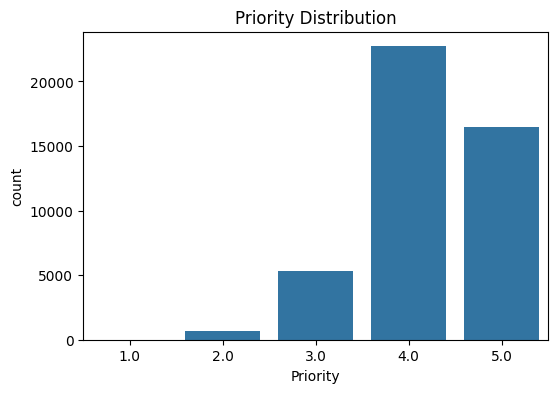

In [8]:
# Plot priority distribution
if 'Priority' in df.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df['Priority'])
    plt.title("Priority Distribution")
    plt.show()

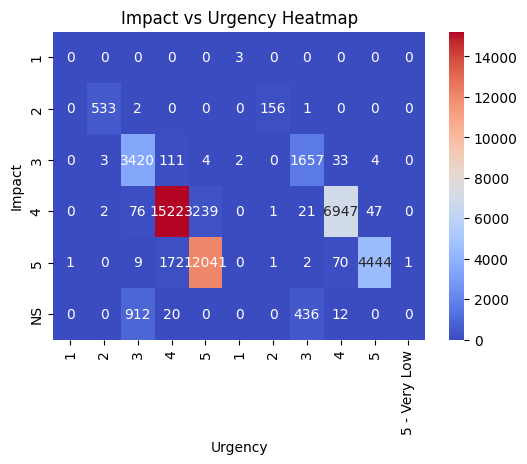

In [9]:
# Plot impact vs urgency (heatmap)
if 'Impact' in df.columns and 'Urgency' in df.columns:
    plt.figure(figsize=(6,4))
    sns.heatmap(pd.crosstab(df['Impact'], df['Urgency']), annot=True, fmt='d', cmap="coolwarm")
    plt.title("Impact vs Urgency Heatmap")
    plt.xlabel("Urgency")
    plt.ylabel("Impact")
    plt.show()

In [10]:
### 📌 Step 2: Data Preprocessing ###
# Drop unnecessary columns
drop_cols = ['Incident_ID', 'CI_Name', 'WBS', 'KB_number', 'Related_Interaction', 'Related_Change']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

In [11]:
# Convert categorical columns to numerical
cat_cols = df.select_dtypes(include=['object']).columns
label_enc = LabelEncoder()
for col in cat_cols:
    df[col] = label_enc.fit_transform(df[col].astype(str))


In [12]:
# Handle missing values
df.fillna(df.median(), inplace=True)


In [13]:
# Define features and target
X = df.drop(columns=['Priority'])
y = df['Priority'].fillna(df['Priority'].median())

# Shift class labels to start from 0
y = y - y.min()


In [14]:
# Check class distribution
class_counts = Counter(y)
min_samples = min(class_counts.values())


In [15]:
# Fix SMOTE Issue: Ensure k_neighbors is not greater than available samples
k_neighbors = min(3, min_samples - 1) if min_samples > 1 else 1  
smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors, random_state=42)


In [16]:
# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

In [17]:
# Standardize Features
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)



In [18]:
# Split Data into Training & Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)


In [19]:
### ----- STEP 3: TRAIN MODELS SEPARATELY -----

# Initialize an empty dictionary before training models
model_accuracies = {}

# Function to Train a Model
def train_model(model, model_name):
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Store accuracy in the dictionary
    model_accuracies[model_name] = acc

    return acc



Training Logistic Regression...
Accuracy: 0.9995
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4820
         1.0       1.00      1.00      1.00      4819
         2.0       1.00      1.00      1.00      4819
         3.0       1.00      1.00      1.00      4820
         4.0       1.00      1.00      1.00      4819

    accuracy                           1.00     24097
   macro avg       1.00      1.00      1.00     24097
weighted avg       1.00      1.00      1.00     24097



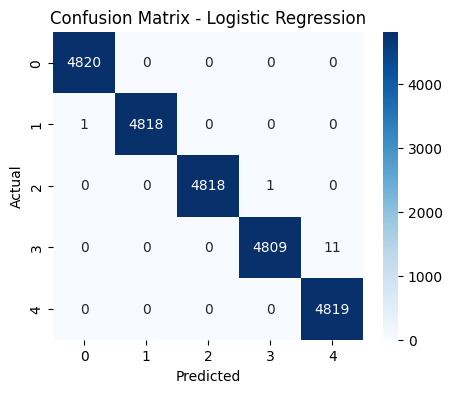


Training Decision Tree...
Accuracy: 0.9992
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4820
         1.0       1.00      1.00      1.00      4819
         2.0       1.00      1.00      1.00      4819
         3.0       1.00      1.00      1.00      4820
         4.0       1.00      1.00      1.00      4819

    accuracy                           1.00     24097
   macro avg       1.00      1.00      1.00     24097
weighted avg       1.00      1.00      1.00     24097



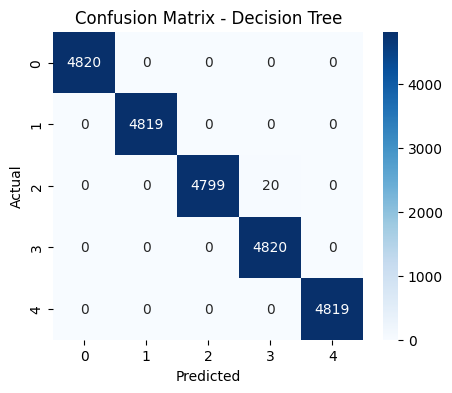


Training Random Forest...
Accuracy: 0.9973
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4820
         1.0       1.00      1.00      1.00      4819
         2.0       1.00      1.00      1.00      4819
         3.0       1.00      0.99      0.99      4820
         4.0       0.99      1.00      1.00      4819

    accuracy                           1.00     24097
   macro avg       1.00      1.00      1.00     24097
weighted avg       1.00      1.00      1.00     24097



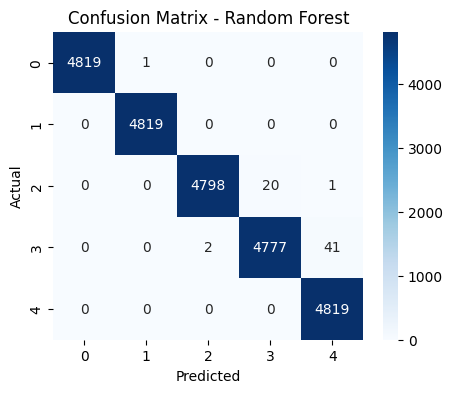

In [20]:
# Train Logistic Regression
logistic_model = LogisticRegression()
acc_logistic = train_model(logistic_model, "Logistic Regression")

# Train Decision Tree
decision_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=10)
acc_decision_tree = train_model(decision_tree, "Decision Tree")

# Train Random Forest
random_forest = RandomForestClassifier(max_depth=5, n_estimators=100)
acc_random_forest = train_model(random_forest, "Random Forest")



In [21]:
# Print Model Accuracies
print("\nModel Performance Comparison:")
for model, acc in model_accuracies.items():
    print(f"{model}: {acc:.4f}")


Model Performance Comparison:
Logistic Regression: 0.9995
Decision Tree: 0.9992
Random Forest: 0.9973
